# Import all the necessary dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from colorama import Fore, Style
from abc import ABC, abstractmethod
from typing import Callable, List, Optional, Dict, Tuple
from dataclasses import dataclass, field
import random

# Signal Generator

In [4]:
class SignalGenerator(ABC):
    @abstractmethod
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """
        data: OHLCV (and extra) up to t‑1
        returns: Series indexed like data of +1 (long), -1 (short), 0 (flat)
        """

In [5]:
class SimpleMAMomentum(SignalGenerator):
    """Long when price > SMA, Short when price < SMA"""
    def __init__(self, window: int = 24):
        self.window = window

    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        close = data['close']
        sma = close.rolling(self.window).mean()

        # Only assign signals where SMA is valid
        signal = pd.Series(0, index=data.index)
        valid = sma.notna()
        signal[valid & (close > sma)] = 1
        signal[valid & (close < sma)] = -1

        return signal


In [6]:
class EnhancedMACDRSIStrategy(SignalGenerator):
    """MACD + RSI with trend/volatility filters — safe for partial slices."""
    def __init__(self,
                 macd_fast=12, macd_slow=26, macd_signal=9,
                 rsi_period=14, rsi_oversold=30, rsi_overbought=70,
                 trend_ema=100, min_volatility=0.005):
        self.fast = macd_fast
        self.slow = macd_slow
        self.signal = macd_signal
        self.rsi_period = rsi_period
        self.rsi_over = rsi_overbought
        self.rsi_under = rsi_oversold
        self.trend_ema = trend_ema
        self.min_vol = min_volatility

    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        if len(data) < max(self.slow, self.rsi_period, self.trend_ema):
            return pd.Series(0, index=data.index)  # not enough data

        df = data.copy()
        close = df['close']

        # MACD
        ema_fast = close.ewm(span=self.fast, adjust=False).mean()
        ema_slow = close.ewm(span=self.slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        macd_signal = macd_line.ewm(span=self.signal, adjust=False).mean()

        # RSI
        delta = close.diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        ema_up = up.ewm(alpha=1/self.rsi_period, adjust=False).mean()
        ema_down = down.ewm(alpha=1/self.rsi_period, adjust=False).mean()
        rs = ema_up / ema_down
        rsi = 100 - (100 / (1 + rs))

        # ATR volatility proxy
        atr = (df['high'] - df['low']) / df['close'].shift(1)
        low_vol = atr < self.min_vol

        # Trend filter
        trend = df['close'] > df['close'].ewm(span=self.trend_ema, adjust=False).mean()

        sig = pd.Series(0, index=df.index)

        # Conditions
        buy = (
            (macd_line > macd_signal) &
            (macd_line.shift() <= macd_signal.shift()) &
            (rsi < self.rsi_under) &
            trend &
            (~low_vol)
        )
        sell = (
            (macd_line < macd_signal) &
            (macd_line.shift() >= macd_signal.shift()) &
            (rsi > self.rsi_over)
        )

        sig[buy] = 1
        sig[sell] = -1
        return sig


# Backtesting Framework

In [8]:
@dataclass
class BacktestConfig:
    start_cash: float = 10000.0
    start_cash: float = 10000.0
    trade_fee: float = 0.0005
    spread: float = 0.0002
    latency_bars: int = 0
    slippage_coef: float = 0.001
    funding_rate: float = 0.0001
    freq_hours: int = 1         # <— hours per bar (1 for hourly data)


In [9]:
class Position:
    def __init__(self, entry_price: float, entry_idx: pd.Timestamp,
                 qty: float, direction: int, entry_cost: float):
        self.entry_price = entry_price
        self.entry_idx = entry_idx
        self.qty = qty
        self.direction = direction
        self.entry_cost = entry_cost
        self.exit_price: Optional[float] = None
        self.exit_idx: Optional[pd.Timestamp] = None
        self.exit_cost: float = 0.0
        self.funding_cost: float = 0.0

    def close(self, price: float, idx: pd.Timestamp, cost: float, funding: float):
        self.exit_price = price
        self.exit_idx = idx
        self.exit_cost = cost
        self.funding_cost = funding

    def pnl(self) -> float:
        gross = (self.exit_price - self.entry_price) * self.qty * self.direction
        return gross - self.entry_cost - self.exit_cost - self.funding_cost

In [10]:
class CostModel:
    def __init__(self, fee: float, spread: float,
                 slippage_coef: float, funding_rate: float):
        self.fee = fee
        self.spread = spread
        self.slippage_coef = slippage_coef
        self.funding_rate = funding_rate

    def entry_cost(self, price: float, qty: float, volume: float) -> float:
        base = price * qty * (self.spread/2 + self.fee)
        impact = price * qty * self.slippage_coef * (qty / volume if volume > 0 else 0)
        return base + impact

    def exit_cost(self, price: float, qty: float, volume: float) -> float:
        base = price * qty * (self.spread/2 + self.fee)
        impact = price * qty * self.slippage_coef * (qty / volume if volume > 0 else 0)
        return base + impact

    def funding_cost(self, price: float, qty: float, direction: int, bars: int) -> float:
        return price * qty * abs(direction) * self.funding_rate * bars

In [11]:
class PositionManager:
    def __init__(self, cost_model: CostModel, data: pd.DataFrame):
        self.cm = cost_model
        self.data = data
        if 'volume' in data:
            # ignore zeros, take at least 1 if still zero
            vol = data['volume'].replace(0, np.nan).mean()
            self.default_volume = vol if not np.isnan(vol) and vol > 0 else 1.0
        else:
            self.default_volume = 1.0

    def run(self, signals: pd.Series) -> List[Position]:
        positions: List[Position] = []
        current: Optional[Position] = None
        last_idx = self.data.index[-1]

        for idx, sig in signals.items():
            price = self.data.at[idx, 'close']
            vol = self.data.at[idx, 'volume'] if 'volume' in self.data else np.nan
            volume = vol if (not np.isnan(vol) and vol > 0) else self.default_volume

            # LONG entry only when sig == 1
            if current is None and sig == 1:
                qty = 1.0
                ec = self.cm.entry_cost(price, qty, volume)
                current = Position(price, idx, qty, 1, ec)

            # Exit any open long when sig != 1
            elif current is not None and sig != 1:
                bars_held = (self.data.index.get_loc(idx)
                             - self.data.index.get_loc(current.entry_idx))
                xc = self.cm.exit_cost(price, current.qty, volume)
                fc = self.cm.funding_cost(
                    current.entry_price,
                    current.qty,
                    current.direction,
                    bars_held
                )
                current.close(price, idx, xc, fc)
                positions.append(current)
                current = None

        # force‑close at end
        if current is not None:
            price = self.data.at[last_idx, 'close']
            vol = self.data.at[last_idx, 'volume'] if 'volume' in self.data else np.nan
            volume = vol if (not np.isnan(vol) and vol > 0) else self.default_volume
            bars_held = (self.data.index.get_loc(last_idx)
                         - self.data.index.get_loc(current.entry_idx))
            xc = self.cm.exit_cost(price, current.qty, volume)
            fc = self.cm.funding_cost(
                current.entry_price,
                current.qty,
                current.direction,
                bars_held
            )
            current.close(price, last_idx, xc, fc)
            positions.append(current)

        return positions

In [12]:
class MetricsTracker:
    def compute(self,
                data: pd.DataFrame,
                config: BacktestConfig,
                positions: List[Position]
               ) -> Tuple[dict, pd.Series]:
        
        # 1) Build equity curve, forward‑fill, then fill initial with start_cash
        eq = self.equity_curve(data, config, positions).ffill()
        eq = eq.fillna(config.start_cash)

        # 2) Returns & Sharpe, annualized for hourly bars
        #    periods per year = 365 days * 24h / freq_hours
        periods_per_year = 365 * 24 / config.freq_hours
        returns = eq.pct_change().dropna()
        sharpe = (returns.mean() / returns.std() * np.sqrt(periods_per_year)
                  if returns.std() > 0 else 0.0)

        # 3) Max drawdown as percentage
        raw_dd     = (eq / eq.cummax() - 1).min()   # e.g. –0.20
        max_dd_pct = raw_dd * 100                  # e.g. 20.0

        # 4) Per‑trade stats
        wins       = [p.pnl() for p in positions if p.pnl() > 0]
        losses     = [p.pnl() for p in positions if p.pnl() < 0]
        trade_count = len(positions)
        win_rate    = len(wins) / trade_count if trade_count else 0.0
        avg_win     = np.mean(wins)   if wins   else 0.0
        avg_loss    = np.mean(losses) if losses else 0.0

        # 5) Profit Factor: NaN if no losing trades
        if losses:
            profit_factor = sum(wins) / -sum(losses)
        else:
            profit_factor = float('nan')

        # 6) Initial & Final cash
        initial_cash = config.start_cash
        final_cash   = eq.iloc[-1]

        stats = {
            'Sharpe': sharpe,
            'Max Drawdown (%)': max_dd_pct,
            'Trade Count': trade_count,
            'Win Rate': win_rate,
            'Avg Win': avg_win,
            'Avg Loss': avg_loss,
            'Profit Factor': profit_factor,
            'Initial Cash': initial_cash,
            'Final Cash': final_cash
        }
        return stats, eq

    def equity_curve(self,
                     data: pd.DataFrame,
                     config: BacktestConfig,
                     positions: List[Position]
                    ) -> pd.Series:
        eq = pd.Series(index=data.index, dtype=float)
        cash = config.start_cash

        # map entries/exits by timestamp
        entry_map = {p.entry_idx: p for p in positions}
        exit_map  = {p.exit_idx:  p for p in positions}

        open_pos = None
        for idx, row in data.iterrows():
            # entry
            if idx in entry_map:
                p = entry_map[idx]
                if p.direction == 1:
                    cash -= p.qty * p.entry_price + p.entry_cost
                else:
                    cash += p.qty * p.entry_price - p.entry_cost
                open_pos = p

            # exit
            if idx in exit_map:
                p = exit_map[idx]
                if p.direction == 1:
                    cash += p.qty * p.exit_price \
                            - p.exit_cost - p.funding_cost
                else:
                    cash -= p.qty * p.exit_price \
                            + p.exit_cost + p.funding_cost
                open_pos = None

            # mark‑to‑market any open position
            unreal = 0.0
            if open_pos is not None:
                unreal = ((row['close'] - open_pos.entry_price)
                          * open_pos.qty * open_pos.direction)

            eq.at[idx] = cash + unreal

        return eq

In [13]:
from tqdm import tqdm  # optional, slow loop guard

class Backtester:
    def __init__(self, data, signal_generator, config):
        self.data   = data.copy()
        self.sg     = signal_generator
        self.config = config
        self.cm     = CostModel(config.trade_fee,
                                config.spread,
                                config.slippage_coef,
                                config.funding_rate)

    def run(self):
        # 1) Prepare an all‑zero, index‑aligned signal series
        signals = pd.Series(0, index=self.data.index, dtype=int)

        # 2) Walk forward bar by bar
        #    Starting at the first bar where a signal could be computed:
        start_bar = self.config.latency_bars + 1

        for ts in tqdm(self.data.index[start_bar:], desc="Walk‑forward"):
            pos    = self.data.index.get_loc(ts)
            cutoff = pos - self.config.latency_bars
            past   = self.data.iloc[:max(cutoff, 0)]
            sig_series = self.sg.generate_signals(past)
            latest     = int(sig_series.iloc[-1]) if len(sig_series) else 0
            signals.at[ts] = latest

        # 3) Quick sanity check—make sure not all zeros
        if signals.abs().sum() == 0:
            raise RuntimeError(
                "No non‑zero signals found!  "
                "Either your window is too large or your generator isn't firing."
            )

        # 4) Run your position logic
        pm = PositionManager(self.cm, self.data)
        positions = pm.run(signals)

        # 5) Compute metrics & plot
        mt = MetricsTracker()
        stats, equity = mt.compute(self.data, self.config, positions)
        self.plot(self.data, equity, signals)

        for k, v in stats.items():
            print(f"{k}: {v:.4f}")
        return stats


    def plot(self, data: pd.DataFrame, equity: pd.Series, signals: pd.Series):
        fig, ax = plt.subplots(figsize=(12, 6))
    
        # — Price line
        ax.plot(data.index, data['close'], label='Price', linewidth=1.5)
    
        # — Equity curve line
        ax.plot(equity.index, equity.values, label='Equity', linewidth=1.5)
    
        # — Signal markers
        long_signals  = signals[signals == 1].index
        short_signals = signals[signals == -1].index
        ax.scatter(long_signals,  data.loc[long_signals, 'close'],
                   marker='^', color='green', s=80, label='Long Signal')
        ax.scatter(short_signals, data.loc[short_signals, 'close'],
                   marker='v', color='red', s=80, label='Short Signal')
    
        # — Labels & legend
        ax.set_title('Price & Equity with Signals')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend(loc='best')
    
        plt.show()

# Running the code

In [15]:
df = pd.read_csv("ohlcv.csv", dtype={"start_time": int})

# Convert 'datetime' column to proper datetime format
df["datetime"] = pd.to_datetime(df["datetime"])

# Drop 'start_time' column if it exists
df.drop(columns=["start_time"], inplace=True, errors="ignore")

# Set 'datetime' as the index and sort it
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

df

,close,high,low,open,volume
datetime,,,,,
2024-01-01 00:00:00,42475.23,42554.57,42261.02,42283.58,1271.68108
2024-01-01 01:00:00,42613.56,42775.00,42431.65,42475.23,1196.37856
2024-01-01 02:00:00,42581.10,42638.41,42500.00,42613.57,685.21980
2024-01-01 03:00:00,42330.49,42586.64,42230.08,42581.09,794.80391
2024-01-01 04:00:00,42399.99,42399.99,42209.46,42330.50,715.41760
...,...,...,...,...,...
2024-12-31 19:00:00,94166.88,94290.91,93712.45,93875.69,462.79342
2024-12-31 20:00:00,93564.04,94222.50,93450.17,94166.88,733.04147
2024-12-31 21:00:00,93899.68,93964.15,93504.67,93564.01,337.52715


=== SMA Momentum Results ===


Walk‑forward: 100%|███████████████████████████████████████████████████████████████| 8781/8781 [00:18<00:00, 481.88it/s]


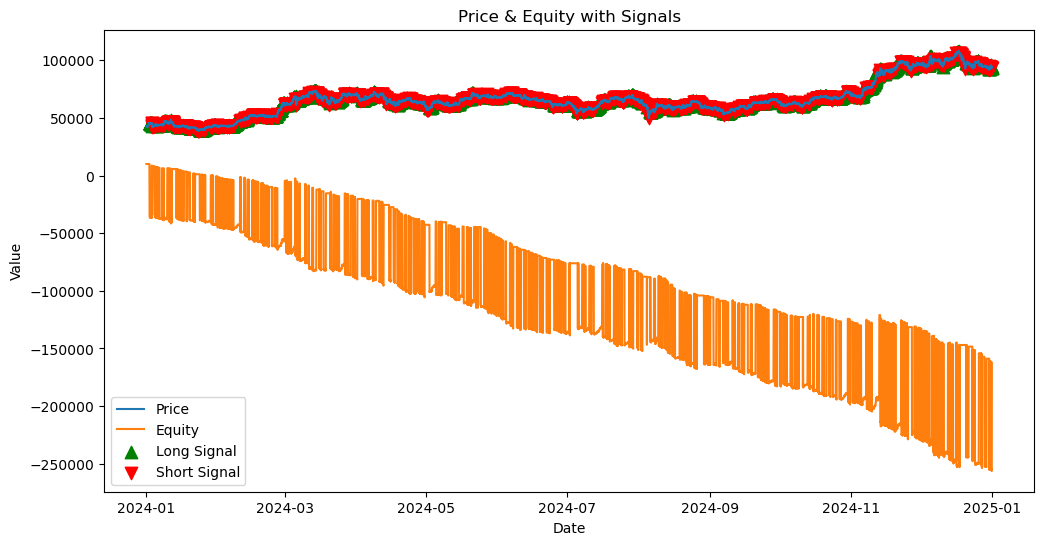

Sharpe: -0.8959
Max Drawdown (%): -2660.7849
Trade Count: 447.0000
Win Rate: 0.2371
Avg Win: 704.9619
Avg Loss: -724.6531
Profit Factor: 0.3024
Initial Cash: 10000.0000
Final Cash: -162380.7480

=== MACD+RSI Results ===


Walk‑forward: 100%|███████████████████████████████████████████████████████████████| 8781/8781 [00:57<00:00, 153.19it/s]


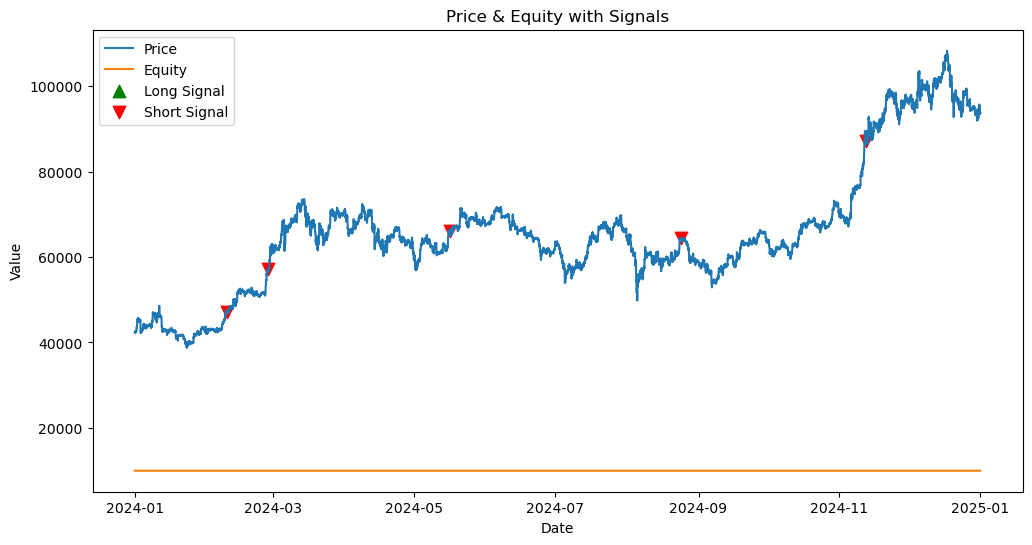

Sharpe: 0.0000
Max Drawdown (%): 0.0000
Trade Count: 0.0000
Win Rate: 0.0000
Avg Win: 0.0000
Avg Loss: 0.0000
Profit Factor: nan
Initial Cash: 10000.0000
Final Cash: 10000.0000


In [16]:
cfg = BacktestConfig(
    start_cash=10000.0,      # ✅ correct
    trade_fee=0.0005,
    spread=0.0002,
    latency_bars=2,
    slippage_coef=0.002,
    funding_rate=0.0005
)

# 3) Run SMA‑momentum strategy
sma_strat = SimpleMAMomentum(window=30)
bt_sma = Backtester(df, sma_strat, cfg)
print("=== SMA Momentum Results ===")
res_sma = bt_sma.run()

# # 4) Run MACD+RSI strategy
macd_strat = EnhancedMACDRSIStrategy()
bt_macd = Backtester(df, macd_strat, cfg)
print("\n=== MACD+RSI Results ===")
res_macd = bt_macd.run()

# Testing

Sharpe Ratio        : 0.0188
Max Drawdown (PnL)  : -0.3440
Trade Frequency (%) : 0.01


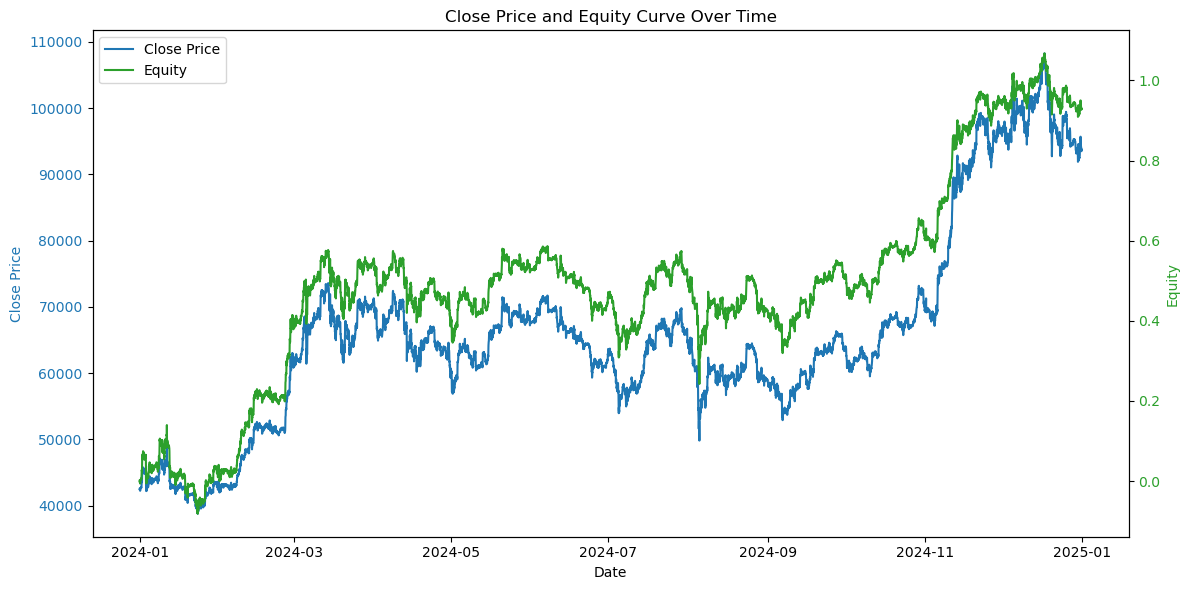

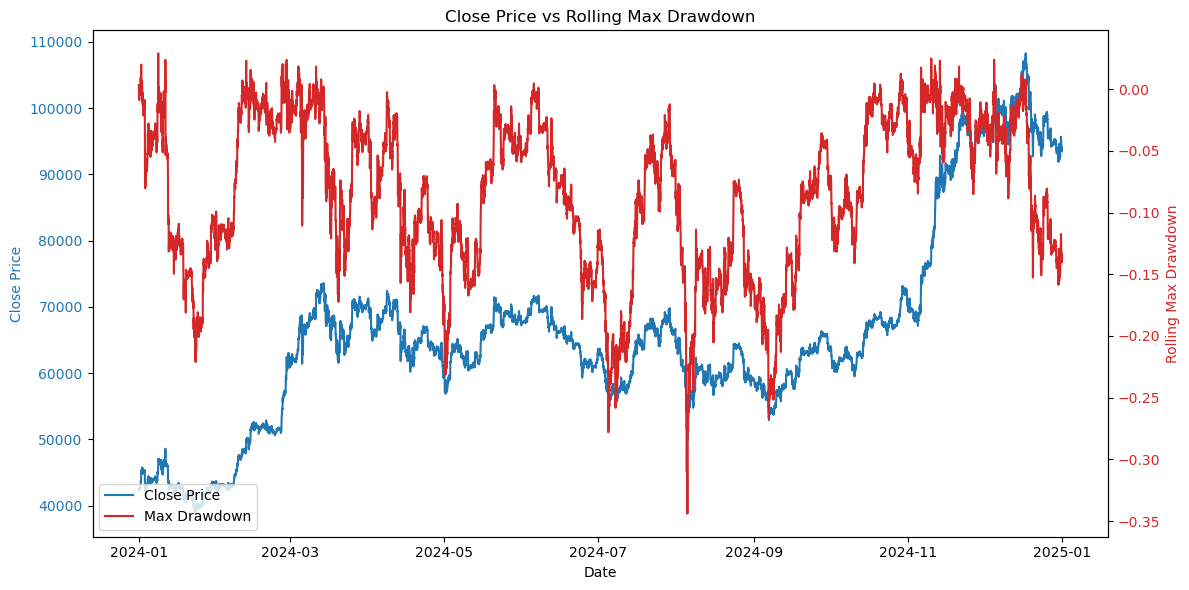

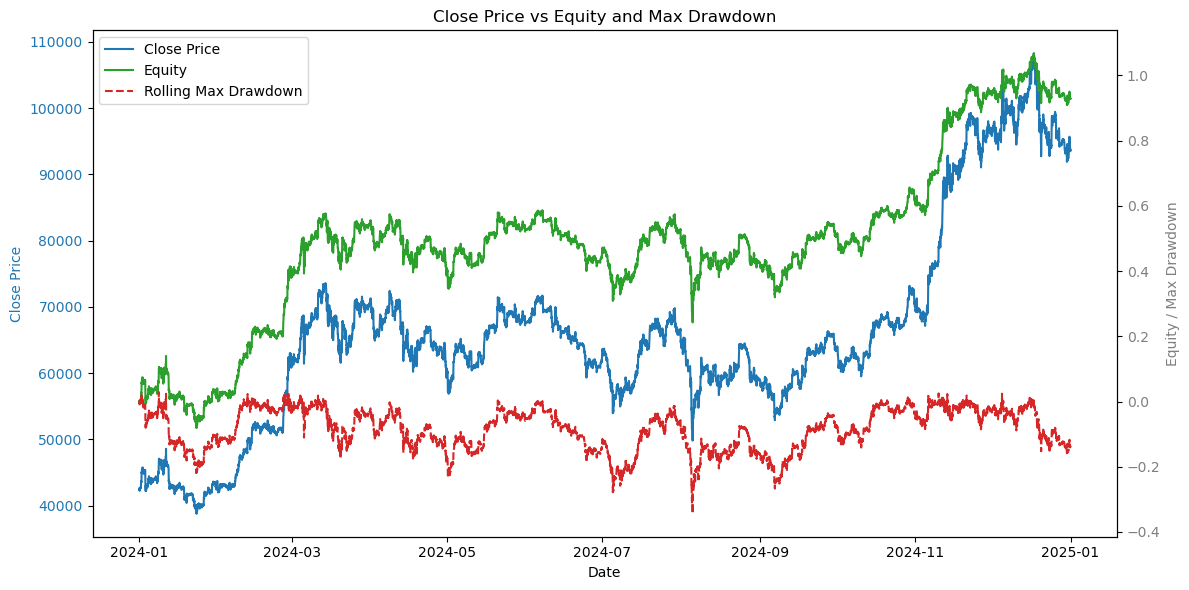

In [52]:
import numpy as np
import pandas as pd

# Example setup — assuming df is your OHLCV DataFrame
data = df.copy()

# Create random positions: -1 (short), 0 (neutral), 1 (long)
np.random.seed(42)
dalh vccccccr4ee

# Config setup
config = BacktestConfig(
    start_cash=10000.0,
    trade_fee=0.0005,
    spread=0.0002,
    latency_bars=2,
    slippage_coef=0.002,
    funding_rate=0.0005
)

# === Metrics Computation ===

# 1) Price change
price_change = data['close'].pct_change().fillna(0)

# 2) Previous positions and trades
positions = data['positions']
prev_pos = positions.shift(1).fillna(0)
trades = (positions - prev_pos).abs()

# 3) Raw PnL
pnl_raw = prev_pos * price_change

# 4) Trading cost (as % of price)
trade_cost = trades * config.trade_fee
trade_cost = trade_cost.fillna(0)

# 5) Net PnL
pnl = pnl_raw - trade_cost

# 6) Equity curve
equity = pnl.cumsum()

# 7) Sharpe ratio
sharpe = pnl.mean() / pnl.std() if pnl.std() > 0 else 0.0

# 8) Max drawdown
drawdown = equity - equity.cummax()
max_dd = drawdown.min()

# 9) Trade frequency
trade_freq_pct = trades.sum() / len(data) * 100

# === Append results to data ===
data['prev_pos'] = prev_pos
data['price_change'] = price_change
data['trades'] = trades
data['pnl'] = pnl
data['equity'] = equity
data['max_dd'] = data['equity'] - data['equity'].shift(1).expanding().max()

# === Print summary ===
print(f"Sharpe Ratio        : {sharpe:.4f}")
print(f"Max Drawdown (PnL)  : {max_dd:.4f}")
print(f"Trade Frequency (%) : {trade_freq_pct:.2f}")

import matplotlib.pyplot as plt

# Create the figure and axes
fig, ax_price = plt.subplots(figsize=(12, 6))
ax_equity = ax_price.twinx()

# Plot close price (left y-axis)
ax_price.plot(data.index, data['close'], label='Close Price', color='tab:blue', linewidth=1.5)
ax_price.set_ylabel('Close Price', color='tab:blue')
ax_price.tick_params(axis='y', labelcolor='tab:blue')

# Plot equity (right y-axis)
ax_equity.plot(data.index, data['equity'], label='Equity', color='tab:green', linewidth=1.5)
ax_equity.set_ylabel('Equity', color='tab:green')
ax_equity.tick_params(axis='y', labelcolor='tab:green')

# Set title and labels
ax_price.set_title('Close Price and Equity Curve Over Time')
ax_price.set_xlabel('Date')

# Show legends
lines1, labels1 = ax_price.get_legend_handles_labels()
lines2, labels2 = ax_equity.get_legend_handles_labels()
ax_price.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# === Plot: Close Price vs Rolling Max Drawdown ===
fig, ax_price = plt.subplots(figsize=(12, 6))
ax_dd = ax_price.twinx()

# Plot Close Price on left y-axis
ax_price.plot(data.index, data['close'], label='Close Price', color='tab:blue', linewidth=1.5)
ax_price.set_ylabel('Close Price', color='tab:blue')
ax_price.tick_params(axis='y', labelcolor='tab:blue')

# Plot Max Drawdown on right y-axis
ax_dd.plot(data.index, data['max_dd'], label='Max Drawdown', color='tab:red', linewidth=1.5)
ax_dd.set_ylabel('Rolling Max Drawdown', color='tab:red')
ax_dd.tick_params(axis='y', labelcolor='tab:red')

# Title and x-axis
ax_price.set_title('Close Price vs Rolling Max Drawdown')
ax_price.set_xlabel('Date')

# Combined Legend
lines1, labels1 = ax_price.get_legend_handles_labels()
lines2, labels2 = ax_dd.get_legend_handles_labels()
ax_price.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# === Second Plot: Close Price vs Equity & Max Drawdown ===
fig, ax_price = plt.subplots(figsize=(12, 6))
ax_right = ax_price.twinx()

# Left Y-axis: Close Price
ax_price.plot(data.index, data['close'], label='Close Price', color='tab:blue', linewidth=1.5)
ax_price.set_ylabel('Close Price', color='tab:blue')
ax_price.tick_params(axis='y', labelcolor='tab:blue')

# Right Y-axis: Equity and Max Drawdown
ax_right.plot(data.index, data['equity'], label='Equity', color='tab:green', linewidth=1.5)
ax_right.plot(data.index, data['max_dd'], label='Rolling Max Drawdown', color='tab:red', linewidth=1.5, linestyle='--')
ax_right.set_ylabel('Equity / Max Drawdown', color='tab:gray')
ax_right.tick_params(axis='y', labelcolor='tab:gray')

# Title and x-axis
ax_price.set_title('Close Price vs Equity and Max Drawdown')
ax_price.set_xlabel('Date')

# Combined Legend
lines1, labels1 = ax_price.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax_price.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()



In [54]:
data

,close,high,low,open,volume,positions,prev_pos,price_change,trades,pnl,equity,max_dd
datetime,,,,,,,,,,,,
2024-01-01 00:00:00,42475.23,42554.57,42261.02,42283.58,1271.68108,1.0,0.0,0.000000,1.0,-0.000500,-0.000500,NaN
2024-01-01 01:00:00,42613.56,42775.00,42431.65,42475.23,1196.37856,1.0,1.0,0.003257,0.0,0.003257,0.002757,0.003257
2024-01-01 02:00:00,42581.10,42638.41,42500.00,42613.57,685.21980,1.0,1.0,-0.000762,0.0,-0.000762,0.001995,-0.000762
2024-01-01 03:00:00,42330.49,42586.64,42230.08,42581.09,794.80391,1.0,1.0,-0.005885,0.0,-0.005885,-0.003890,-0.006647
2024-01-01 04:00:00,42399.99,42399.99,42209.46,42330.50,715.41760,1.0,1.0,0.001642,0.0,0.001642,-0.002249,-0.005005
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,94166.88,94290.91,93712.45,93875.69,462.79342,1.0,1.0,0.003102,0.0,0.003102,0.934273,-0.133273
2024-12-31 20:00:00,93564.04,94222.50,93450.17,94166.88,733.04147,1.0,1.0,-0.006402,0.0,-0.006402,0.927872,-0.139675
2024-12-31 21:00:00,93899.68,93964.15,93504.67,93564.01,337.52715,1.0,1.0,0.003587,0.0,0.003587,0.931459,-0.136088
